**MODELING TRAFFIC CONGESTION WITH STREET PARAMETERS**

In February 2019, The City of Barcelona enacted a new traffic policy called *The Superblock* on the District of Eixample, this policy modified some roads from two ways lane into one way lane, and convert some road into a 'pedestrian only' area.

Although it increase the livability of the city, it also increase the overall traffic congestion and creating new congestion hotspots in some road sections. Through this project we will try to model the congestion level based on different street parameter that each traffic sensor location possess.

Overall, it will consist of five stages of process, namely:
1. Initial Mapping
2. Exploratory Spatial Data Analysis (ESDA)
3. Machine Learning Method Selection
4. Feature Importance
5. Machine Learning Predictor

Author: M. Tsaqif Wismadi

**Importing Libraries**

In [1]:
#List of libraries
import contextily as cx
import pandas as pd
import geopandas as gpd
import geoplot
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


**1. Initial Mapping**

In [2]:
#Importing the pre-superblock data
df1 = gpd.read_file(r"clustering data pre SB.shp")
df1.head(3)

,street_nam,long,lat,idTram,l_section,n_vertices,blocked_r,half_r,cluster,congestion,NR,CR,TR,XR,stan_LS,stan_NV,stan_BR,stan_HR,geometry
0,Diagonal (Pl. Francesc Macià a Balmes),2.145089,41.392758,103,5.469444,35.0,0.0,0.0,0.0,1.882353,1.000000,0.000000,0.457143,0.542857,0.643128,0.555556,0.0,0.0,POINT (2.14509 41.39276)
1,Diagonal (Pl. Francesc Macià a Balmes),2.154834,41.395224,103,4.950746,28.0,0.0,0.0,0.0,1.882353,0.928571,0.071429,0.269231,0.730769,0.482241,0.400000,0.0,0.0,POINT (2.15483 41.39522)
2,Diagonal (Balmes a Pl Joan Carles I),2.154850,41.395227,105,4.974501,28.0,0.0,0.0,0.0,2.000000,0.928571,0.071429,0.269231,0.730769,0.489609,0.400000,0.0,0.0,POINT (2.15485 41.39523)


In [3]:
#Importing the post-superblock data
df2 = gpd.read_file(r"clustering data post SB.shp")
df2.head(3)

,street_nam,long,lat,idTram,l_section,n_vertices,blocked_r,half_r,cluster,congestion,NR,CR,TR,XR,stan_LS,stan_NV,stan_BR,stan_HR,geometry
0,Diagonal (Pl. Francesc Macià a Balmes),2.145089,41.392758,103,5.469444,35.0,0.0,0.0,0.0,3.000000,1.000000,0.000000,0.457143,0.542857,0.688852,0.641026,0.0,0.0,POINT (2.14509 41.39276)
1,Diagonal (Pl. Francesc Macià a Balmes),2.154834,41.395224,103,4.950752,28.0,0.0,0.0,0.0,3.000000,0.928571,0.071429,0.269231,0.730769,0.516529,0.461538,0.0,0.0,POINT (2.15483 41.39522)
2,Diagonal (Balmes a Pl Joan Carles I),2.154850,41.395227,105,4.974503,28.0,0.0,0.0,0.0,1.416667,0.928571,0.071429,0.269231,0.730769,0.524420,0.461538,0.0,0.0,POINT (2.15485 41.39523)


In [4]:
#Importing Eixample District Boundary
boundary = gpd.read_file(r"Eixample District.shp")
boundary.head()

,cartodb_id,c_distri,n_distri,homes,dones,area,perim,coord_x,coord_y,web_1,web_2,web_3,geometry
0,2,02,Eixample,123571,142906,7.476392e+06,13902.57398,430243.353657,4.582773e+06,http://www.bcn.cat/eixample,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,"POLYGON ((2.18239 41.39143, 2.18135 41.39222, ..."


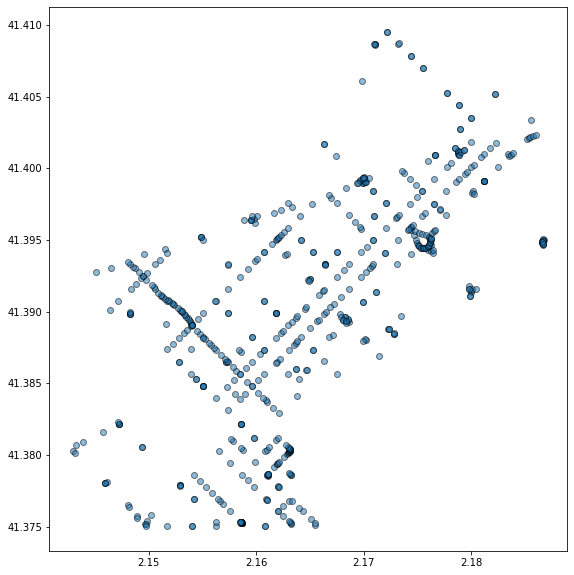

In [5]:
#Check spatial plotting
ax = df1.plot(figsize = (10, 10), alpha = 0.5, edgecolor = 'k')

In [6]:
#Checking coordinate system
df1.crs
df2.crs
boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
#Projecting data to the basemap coordinate
df1_wm = df1.to_crs(epsg = 3857)
df2_wm = df2.to_crs(epsg = 3857)
boundary_wm = boundary.to_crs(epsg = 3857)

<AxesSubplot:>

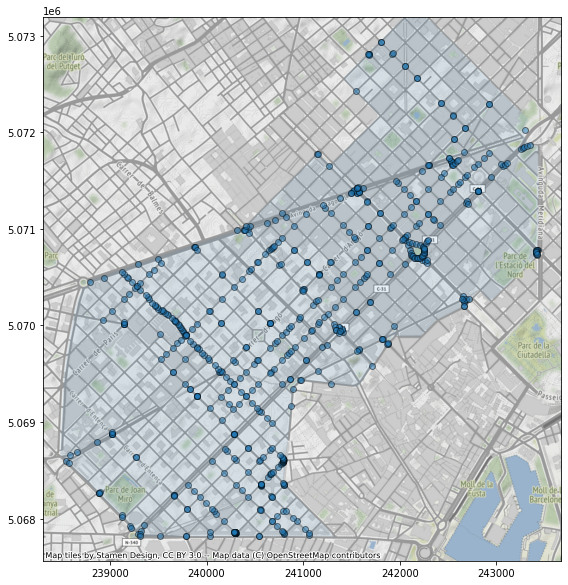

In [8]:
#Adding basemap to data
ax = df1_wm.plot(figsize = (10, 10), alpha = 0.5, edgecolor = 'k')
cx.add_basemap(ax)
boundary_wm.plot(ax = ax, alpha = 0.1)

**2. Exploratory Spatial Data Analysis**

In this section, we will try to map the traffic congestion spread and cluster the traffic point based on their street parameters. Through this step, we will be able to see the congestion different pre and post superblock, as well as change of cluster that the superblock policy created.

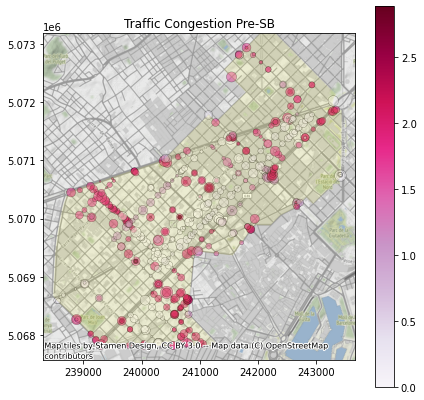

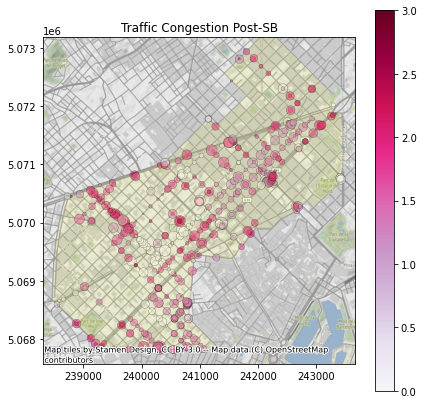

In [9]:
#Comparing the congestion map pre-superblock and post-superblock

#Congestion map pre-superblcok
df1_wm['congestion'] = np.abs(np.random.randn(len(df1_wm))) * 50
ax = df1_wm.plot(markersize = df1_wm['congestion'],
                 figsize = (7, 7),
                 cmap = 'PuRd',
                 alpha = 0.5,
                 column = df1['congestion'],
                 linewidth = 0.4,
                 legend = True,
                 edgecolor = 'black')

cx.add_basemap(ax)
boundary_wm.plot(ax = ax, alpha = 0.1, color = 'yellow')
plt.title("Traffic Congestion Pre-SB")
plt.show()

#Congestion map post-superblcok
df2_wm['congestion'] = np.abs(np.random.randn(len(df2_wm))) * 50
ax = df2_wm.plot(markersize = df2_wm['congestion'],
                 figsize = (7, 7),
                 cmap = 'PuRd',
                 alpha = 0.5,
                 column = df2['congestion'],
                 linewidth = 0.4,
                 legend = True,
                 edgecolor = 'black')

cx.add_basemap(ax)
boundary_wm.plot(ax = ax, alpha = 0.1, color = 'yellow')
plt.title("Traffic Congestion Post-SB")
plt.show()

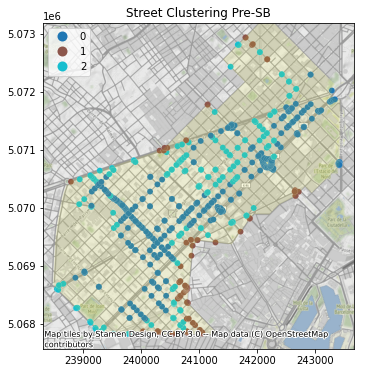

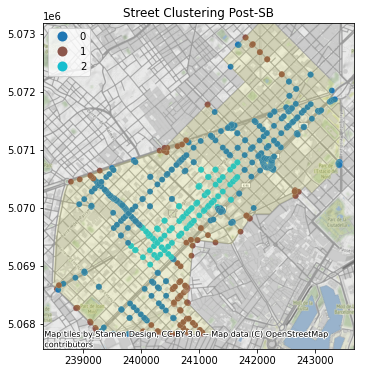

In [10]:
#Clustering the street parameters pre-superblock

#Set up the number of cluster
km4pre = cluster.KMeans(n_clusters = 3)

#Inputing the street network parameters
km4pre_cls = km4pre.fit(df1_wm[['NR', 
                                'CR', 
                                'TR', 
                                'XR', 
                                'stan_LS', 
                                'stan_NV', 
                                'stan_BR',
                                'stan_HR']].values)

#Mapping the clusters
f, ax = plt.subplots(1, figsize = (6, 6))

df1_wm.assign(cl = km4pre_cls.labels_).plot(column = 'cl',
                                     categorical = True,
                                     legend = True,
                                     linewidth = 0.1,
                                     cmap = 'tab10',
                                     edgecolor = 'white',
                                     ax = ax)

cx.add_basemap(ax)
boundary_wm.plot(ax = ax, alpha = 0.1, color = 'yellow')
plt.title("Street Clustering Pre-SB")
plt.show()

#Clustering the street parameters post-superblock

#Set up the number of cluster
km4pre = cluster.KMeans(n_clusters = 3)

#Inputing the street network parameters
km4pre_cls = km4pre.fit(df2_wm[['NR', 
                                'CR', 
                                'TR', 
                                'XR', 
                                'stan_LS', 
                                'stan_NV', 
                                'stan_BR',
                                'stan_HR']].values)

#Mapping the clusters
f, ax = plt.subplots(1, figsize = (6, 6))

df2_wm.assign(cl = km4pre_cls.labels_).plot(column = 'cl',
                                     categorical = True,
                                     legend = True,
                                     linewidth = 0.1,
                                     cmap = 'tab10',
                                     edgecolor = 'white',
                                     ax = ax)

cx.add_basemap(ax)
boundary_wm.plot(ax = ax, alpha = 0.1, color = 'yellow')
plt.title("Street Clustering Post-SB")
plt.show()

**3. Machine Learning Method Selection**

In the following sections, we will try to predict the traffic congestion level (dependent variable) by taking account the street parameters (independent variables) through machine learning modeling.

However, since there are various machine learning methods that we can use for this case, we will try to select the best option between Linear Regression (LR), Decision Tree (DT), and Random Forest (RF). The selection will be based on the r-square and NRMSE value comparison.

In [11]:
#Concatenating pre-superblock dataset and post-superblock dataset into one dataset
frames = [df1, df2]
ML_dataset = pd.concat(frames)

ML_dataset.head(3)

,street_nam,long,lat,idTram,l_section,n_vertices,blocked_r,half_r,cluster,congestion,NR,CR,TR,XR,stan_LS,stan_NV,stan_BR,stan_HR,geometry
0,Diagonal (Pl. Francesc Macià a Balmes),2.145089,41.392758,103,5.469444,35.0,0.0,0.0,0.0,1.882353,1.000000,0.000000,0.457143,0.542857,0.643128,0.555556,0.0,0.0,POINT (2.14509 41.39276)
1,Diagonal (Pl. Francesc Macià a Balmes),2.154834,41.395224,103,4.950746,28.0,0.0,0.0,0.0,1.882353,0.928571,0.071429,0.269231,0.730769,0.482241,0.400000,0.0,0.0,POINT (2.15483 41.39522)
2,Diagonal (Balmes a Pl Joan Carles I),2.154850,41.395227,105,4.974501,28.0,0.0,0.0,0.0,2.000000,0.928571,0.071429,0.269231,0.730769,0.489609,0.400000,0.0,0.0,POINT (2.15485 41.39523)


In [12]:
#WE ASSUME THAT THE CHANGES OF STREET CHARACTER WILL AFFECT THE TRAFFIC CONGESTION CONDITION.

#Defining independent variables (input): all street paremeters and sensor location that the dataset contains.
columns_x = ['long',
             'lat',
             'NR',
             'CR',
             'TR',
             'XR',
             'stan_LS',
             'stan_NV',
             'stan_BR',
             'stan_HR']

x = ML_dataset[columns_x]
x.head(3)

,long,lat,NR,CR,TR,XR,stan_LS,stan_NV,stan_BR,stan_HR
0,2.145089,41.392758,1.000000,0.000000,0.457143,0.542857,0.643128,0.555556,0.0,0.0
1,2.154834,41.395224,0.928571,0.071429,0.269231,0.730769,0.482241,0.400000,0.0,0.0
2,2.154850,41.395227,0.928571,0.071429,0.269231,0.730769,0.489609,0.400000,0.0,0.0


In [13]:
#Defining dependent variables (output): the traffic congestion level.
y = ML_dataset['congestion']
y

0      1.882353
1      1.882353
2      2.000000
3      2.000000
4      1.764706
         ...   
600    1.833333
601    1.833333
602    1.833333
603    1.833333
604    1.000000
Name: congestion, Length: 1210, dtype: float64

In [14]:
# Initializing train and test dataset portion (test dataset 30% from the whole dataset)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [15]:
#CONDUCTING MACHINE LEARNING METHODS ACCURACY TEST
#SELECTION BETWEEN LINEAR REGRESSION, DECISION TREE, AND RANDOM FOREST.

print("Model Performance:\n")

#Linear regression (setting)
lr = linear_regression = LinearRegression()

#Linear regression (accuracy test)
lr.fit(xtrain, ytrain)
ypred1 = lr.predict(xtest)
r2 = round(r2_score(ytest, ypred1), 2)
mse = mean_squared_error(ytest, ypred1)
rmse = round((math.sqrt(mse)), 2)
nrmse = round(rmse / (max(ytest)-min(ytest)), 2)

print("LR r-square accuracy: ", r2)
print("LR NRMSE: ", nrmse)

#Decision tree (setting)
dt = DecisionTreeRegressor()

#Decision tree (accuracy test)
dt.fit(xtrain, ytrain)
ypred2 = dt.predict(xtest)
r2 = round(r2_score(ytest, ypred2), 2)
mse = mean_squared_error(ytest, ypred2)
rmse = round((math.sqrt(mse)), 2)
nrmse = round(rmse / (max(ytest)-min(ytest)), 2)

print("DT r-square accuracy: ", r2)
print("DT NRMSE: ", nrmse)

#Random forest (setting)
rf = RandomForestRegressor()

#Random forest (accuracy test)
rf.fit(xtrain, ytrain)
ypred3 = rf.predict(xtest)
r2 = round(r2_score(ytest, ypred3), 2)
mse = mean_squared_error(ytest, ypred3)
rmse = round((math.sqrt(mse)), 2)
nrmse = round(rmse / (max(ytest)-min(ytest)), 2)

print("RF r-square accuracy: ", r2)
print("RF NRMSE: ", nrmse)

Model Performance:

LR r-square accuracy:  0.08
LR NRMSE:  0.25
DT r-square accuracy:  0.45
DT NRMSE:  0.19
RF r-square accuracy:  0.56
RF NRMSE:  0.17


Text(0.5, 0, 'Actual Congestion')

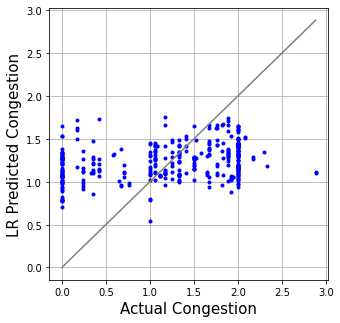

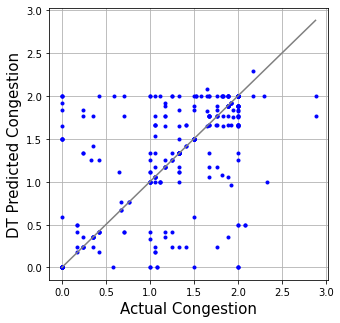

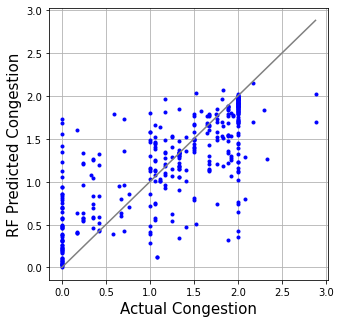

In [16]:
#VISUALING MODEL PERFORMANCE FROM DIFFERENT METHODS

#Plotting the linear regression model performance
fig, ax = plt.subplots(figsize = (5,5))
ax.grid()
ax.plot(ytest, ypred1, '.b')
ax.plot([0, max(ytest)], [0, max(ytest)], color = 'grey')
ax.set_ylabel('LR Predicted Congestion', fontsize = 15)
ax.set_xlabel('Actual Congestion', fontsize = 15)

#Plotting the decision tree model performance
fig, ax = plt.subplots(figsize = (5,5))
ax.grid()
ax.plot(ytest, ypred2, '.b')
ax.plot([0, max(ytest)], [0, max(ytest)], color = 'grey')
ax.set_ylabel('DT Predicted Congestion', fontsize = 15)
ax.set_xlabel('Actual Congestion', fontsize = 15)

#Plotting the random forest model performance
fig, ax = plt.subplots(figsize = (5,5))
ax.grid()
ax.plot(ytest, ypred3, '.b')
ax.plot([0, max(ytest)], [0, max(ytest)], color = 'grey')
ax.set_ylabel('RF Predicted Congestion', fontsize = 15)
ax.set_xlabel('Actual Congestion', fontsize = 15)

**4. Feature Importance**

Referring to the r-square accuracy test, NRMSE score, and the data plotting, we found that random forest method outperform other method, and thus we will go with random forest as our modeling method.

In this stage, we will try to see which independent variables (or in this case 'street parameters') that has the highest effect on traffic congestion.

In [17]:
#Checking feature importance of each street parameters
feature_importance = list (zip (rf.feature_importances_, columns_x))
feature_importance.sort(reverse = True)
feature_importance

[(0.2780475208703721, 'long'),
 (0.18019089867672125, 'lat'),
 (0.1744560268931023, 'stan_LS'),
 (0.09997582519404612, 'stan_NV'),
 (0.09203437507026416, 'XR'),
 (0.0744609535967996, 'TR'),
 (0.04510746588868913, 'stan_HR'),
 (0.022836360763758976, 'NR'),
 (0.01824933163538286, 'CR'),
 (0.014641241410863585, 'stan_BR')]

**5. Machine Learning Predictor**

Now that we have known which method to use and which variables have the highest importance to the model, we can set our machine learning model to predict the traffic congestion level based on street parameters that we input individually.

In [18]:
print('SET YOUR STREET PARAMETERS:\n')

#Creating feedback query
long = float(input('Longitude Point (2-3): '))
lat = float(input('Latitude Point (40-42): '))
NR = float(input('Node Ratio (0-1): '))
CR = float(input('Cul de Sac Ratio (0-1): '))
TR = float(input('T-Junction Ratio (0-1): '))
XR = float(input('X-Junction Ratio (0-1): '))
stan_LS = float(input('Standardized Length of Section (0-1): '))
stan_NV = float(input('Standardized Number of Vertices (0-1): '))
stan_BR = float(input('Standardized Length of Blocked Road Section (0-1): '))
stan_HR = float(input('Standardized Length of Half Road Section (0-1): '))

print('\n')
predictions = rf.predict([[long, lat, NR, CR, TR, XR, stan_LS, stan_NV, stan_BR, stan_HR]])

print('THE ESTIMATED LEVEL OF CONGESTION IN YOUR LOCATION IS: ' + str(*predictions))
print('\n')

SET YOUR STREET PARAMETERS:



Longitude Point (2-3):  2.5
Latitude Point (40-42):  41
Node Ratio (0-1):  0.7
Cul de Sac Ratio (0-1):  0.6
T-Junction Ratio (0-1):  0.5
X-Junction Ratio (0-1):  0.8
Standardized Length of Section (0-1):  0.4
Standardized Number of Vertices (0-1):  0.4
Standardized Length of Blocked Road Section (0-1):  0.5
Standardized Length of Half Road Section (0-1):  0.3




THE ESTIMATED LEVEL OF CONGESTION IN YOUR LOCATION IS: 1.141274509803597




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
